In [22]:
import copy
import numpy as np
from matplotlib import pyplot

from SDM.runner import Runner
from SDM.state import State
from SDM.colliders import SDM
from SDM.discretisations import constant_multiplicity
from SDM.spectra import Exponential
from SDM.kernels import Golovin


In [23]:
def x2r(x):
    return (x * 3/4 / np.pi)**(1/3)

def r2x(r):
    return 4/3 * np.pi * r**3

kg2g = 1e3
m2um = 1e6

In [24]:
class Plotter:
    def __init__(self, setup, xrange):
        self.setup = setup

        self.x_bins = np.logspace(
            (np.log10(xrange[0])),
            (np.log10(xrange[1])),
            num=64,
            endpoint=True
        )
        self.r_bins = x2r(self.x_bins)

    def show(self):
        pyplot.show()

    def save(self, file):
        pyplot.savefig(file)

    def plot(self, state, t):
        s = self.setup

        if t == 0:
            analytic_solution = s.spectrum.size_distribution
        else:
            analytic_solution = lambda x: s.norm_factor * s.kernel.analytic_solution(
                x=x, t=t, x_0=s.X0, N_0=s.n_part
            )

        dm = np.diff(self.x_bins)
        dr = np.diff(self.r_bins)

        pdf_m_x = self.x_bins[:-1] + dm / 2
        pdf_m_y = analytic_solution(pdf_m_x)

        pdf_r_x = self.r_bins[:-1] + dr / 2
        pdf_r_y = pdf_m_y * dm / dr * pdf_r_x

        pyplot.plot(
            m2um * pdf_r_x,
            kg2g * pdf_r_y * r2x(pdf_r_x) * s.rho / s.dv,
            color='black'
        )

        vals = np.empty(len(self.r_bins) - 1)
        for i in range(len(vals)):
            vals[i] = state.moment(1, attr='x', attr_range=(self.x_bins[i], self.x_bins[i + 1]))
            vals[i] *= s.rho / s.dv
            vals[i] /= (np.log(self.r_bins[i + 1]) - np.log(self.r_bins[i]))

        pyplot.step(
            m2um * self.r_bins[:-1],
            kg2g * vals,
            where='post',
            label=f"t = {t}s"
        )
        pyplot.grid()
        pyplot.xscale('log')
        pyplot.xlabel('particle radius [µm]')
        pyplot.ylabel('dm/dlnr [g/m^3/(unit dr/r)]')
        pyplot.legend()




In [25]:
class SetupA:
    x_min = r2x(10e-6)   # not given in the paper
    x_max = r2x(100e-6)  # not given in the paper

    n_sd = 2 ** 13
    n_part = 2 ** 23  # [m-3]
    X0 = 4/3 * np.pi * 30.531e-6**3
    dv = 1e6  # [m3]
    norm_factor = n_part * dv
    rho = 1000  # [kg m-3]

    dt = 1  # [s]
    steps = [0, 1200, 2400]

    kernel = Golovin(b=1.5e3)  # [s-1]
    spectrum = Exponential(norm_factor=norm_factor, scale=X0)

    # TODO: rename?
    def check(self, state, step):
        check_LWC = 1e-3  # kg m-3
        check_ksi = self.n_part * self.dv / self.n_sd

        # multiplicities
        if step == 0:
            np.testing.assert_approx_equal(np.amin(state['n']), np.amax(state['n']), 1)
            np.testing.assert_approx_equal(state['n'][0], check_ksi, 1)

        # liquid water content
        LWC = self.rho * np.dot(state['n'], state['x']) / self.dv
        np.testing.assert_approx_equal(LWC, check_LWC, 3)



In [26]:
def run(setup):
    x, n = constant_multiplicity(setup.n_sd, setup.spectrum, (setup.x_min, setup.x_max))
    state = State(n=n, extensive={'x': x}, intensive={}, segment_num=1)
    collider = SDM(setup.kernel, setup.dt, setup.dv, n_sd=setup.n_sd)
    runner = Runner(state, (collider,))

    states = {}
    for step in setup.steps:
        runner.run(step - runner.n_steps)
        setup.check(runner.state, runner.n_steps)
        states[runner.n_steps] = copy.deepcopy(runner.state)

    return states, runner.stats


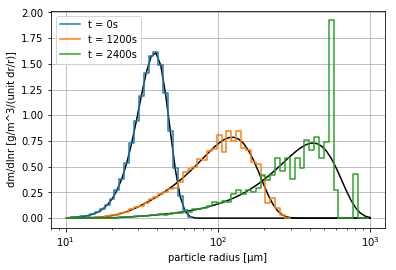

In [27]:
with np.errstate(all='raise'):
    setup = SetupA()
    states, _ = run(setup)

    x_min = min([state.min('x') for state in states.values()])
    x_max = max([state.max('x') for state in states.values()])

with np.errstate(invalid='ignore'):
    plotter = Plotter(setup, (x_min, x_max))
    for step, state in states.items():
        plotter.plot(state, step * setup.dt)
    plotter.show()


In [ ]:
# TODO python -O
def test_timing():
    setup = SetupA()
    setup.steps = [100, 3600]

    nsds = [2 ** n for n in range(12, 15)]
    times = []
    for sd in nsds:
        setup.n_sd = sd
        _, stats = run(setup)
        times.append(stats.times[-1])

    from matplotlib import pyplot as plt
    plt.plot(nsds, times)
    plt.show()
